🔹 Loading neural data...
Neural data averaged: (39209, 118)
🔹 Loading ViT embeddings...
ViT embeddings shape: (118, 1000)
Selecting 44 PCs (covering 90.31% variance)
🔹 Loading permutation test results...
   neuron_idx     r_pc1    p_perm
0           0  0.013737  0.895105
1           1  0.160575  0.093906
2           2  0.175615  0.042957
3           3 -0.000108  1.000000
4           4 -0.012887  0.890110
Top 5 neurons: [26870 35112 23122  8014 30133]
Bottom 5 neurons: [18738 20605  1466 23412 23787]


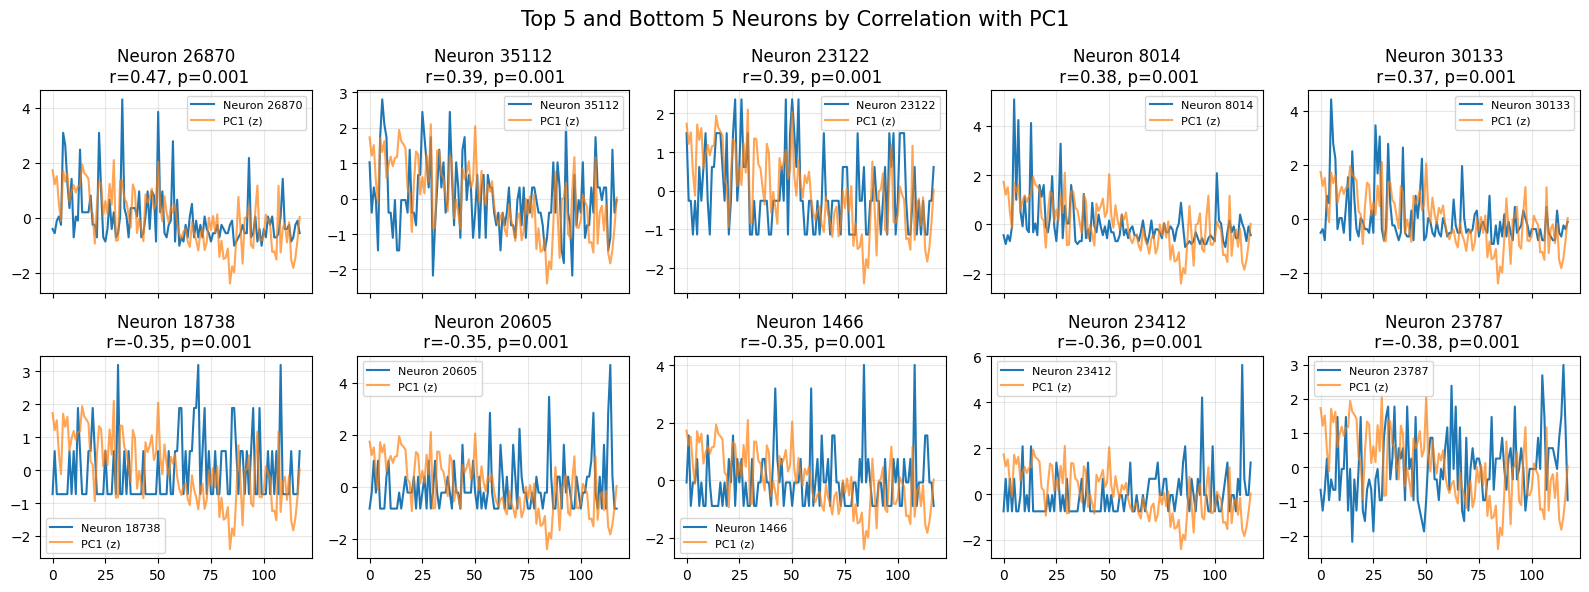

In [11]:
#!/usr/bin/env python3
"""
Visualize top/bottom neurons by correlation with PC1
Loads:
  - neural data (averaged over repeats)
  - PC1 scores
  - permutation-based correlation file (corr_pc1_perm.csv)
Then plots top-5 and bottom-5 neurons' tuning vs PC1.
"""

import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import softmax
from skbio.stats.composition import clr
from sklearn.decomposition import PCA

# ---------------------------------------------------------------
# PATHS
# ---------------------------------------------------------------
VIT_PATH = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy'
PERM_PATH = 'corr_pc1_perm.csv'

N_IMAGES = 118
REPEATS_PER_IMAGE = 50  # 5900 = 118 × 50

# ---------------------------------------------------------------
# LOAD NEURAL DATA
# ---------------------------------------------------------------
print("🔹 Loading neural data...")
dat = np.load(NEURAL_PATH)  # (n_neurons, 5900)
n_neurons, n_trials = dat.shape
assert n_trials == N_IMAGES * REPEATS_PER_IMAGE, "Trial count must equal images × repeats"
dat_img_rep = dat.reshape(n_neurons, N_IMAGES, REPEATS_PER_IMAGE)
firing_mean = dat_img_rep.mean(axis=2)  # (n_neurons, 118)
print(f"Neural data averaged: {firing_mean.shape}")

# ---------------------------------------------------------------
# LOAD AND TRANSFORM ViT EMBEDDINGS → PC1
# ---------------------------------------------------------------
print("🔹 Loading ViT embeddings...")
with open(VIT_PATH, 'rb') as f:
    vit_arr = pickle.load(f)['natural_scenes']
embeddings = np.asarray(vit_arr)
print("ViT embeddings shape:", embeddings.shape)

# softmax + CLR + PCA
X = softmax(embeddings, axis=1)
X_clr = clr(X + 1e-12)

pca_full = PCA().fit(X_clr)
cumvar = np.cumsum(pca_full.explained_variance_ratio_)
n_components = np.searchsorted(cumvar, 0.90) + 1
print(f"Selecting {n_components} PCs (covering {100*cumvar[n_components-1]:.2f}% variance)")

pca = PCA(n_components=n_components, random_state=0)
U = pca.fit_transform(X_clr)
pc1 = U[:, 0]  # (118,)
pc1_z = (pc1 - pc1.mean()) / pc1.std()

# ---------------------------------------------------------------
# LOAD PERMUTATION RESULTS
# ---------------------------------------------------------------
print("🔹 Loading permutation test results...")
df_perm = pd.read_csv(PERM_PATH)
print(df_perm.head())

# ---------------------------------------------------------------
# SELECT NEURONS
# ---------------------------------------------------------------
df_sorted = df_perm.sort_values("r_pc1", ascending=False, ignore_index=True)
top5 = df_sorted.head(5)["neuron_idx"].to_numpy(dtype=int)
bottom5 = df_sorted.tail(5)["neuron_idx"].to_numpy(dtype=int)
selected = np.concatenate([top5, bottom5])
print(f"Top 5 neurons: {top5}")
print(f"Bottom 5 neurons: {bottom5}")

# ---------------------------------------------------------------
# PLOT
# ---------------------------------------------------------------
fig, axes = plt.subplots(2, 5, figsize=(16, 6), sharex=True)
axes = axes.ravel()

for i, idx in enumerate(selected):
    ax = axes[i]
    y = firing_mean[idx]
    y_z = (y - y.mean()) / y.std()
    
    ax.plot(y_z, label=f"Neuron {idx}", color="tab:blue", lw=1.5)
    ax.plot(pc1_z, label="PC1 (z)", color="tab:orange", alpha=0.7)
    
    r_val = df_perm.loc[df_perm["neuron_idx"] == idx, "r_pc1"].values[0]
    p_val = df_perm.loc[df_perm["neuron_idx"] == idx, "p_perm"].values[0]
    ax.set_title(f"Neuron {idx}\n r={r_val:.2f}, p={p_val:.3f}")
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

fig.suptitle("Top 5 and Bottom 5 Neurons by Correlation with PC1", fontsize=15)
plt.tight_layout()
plt.show()


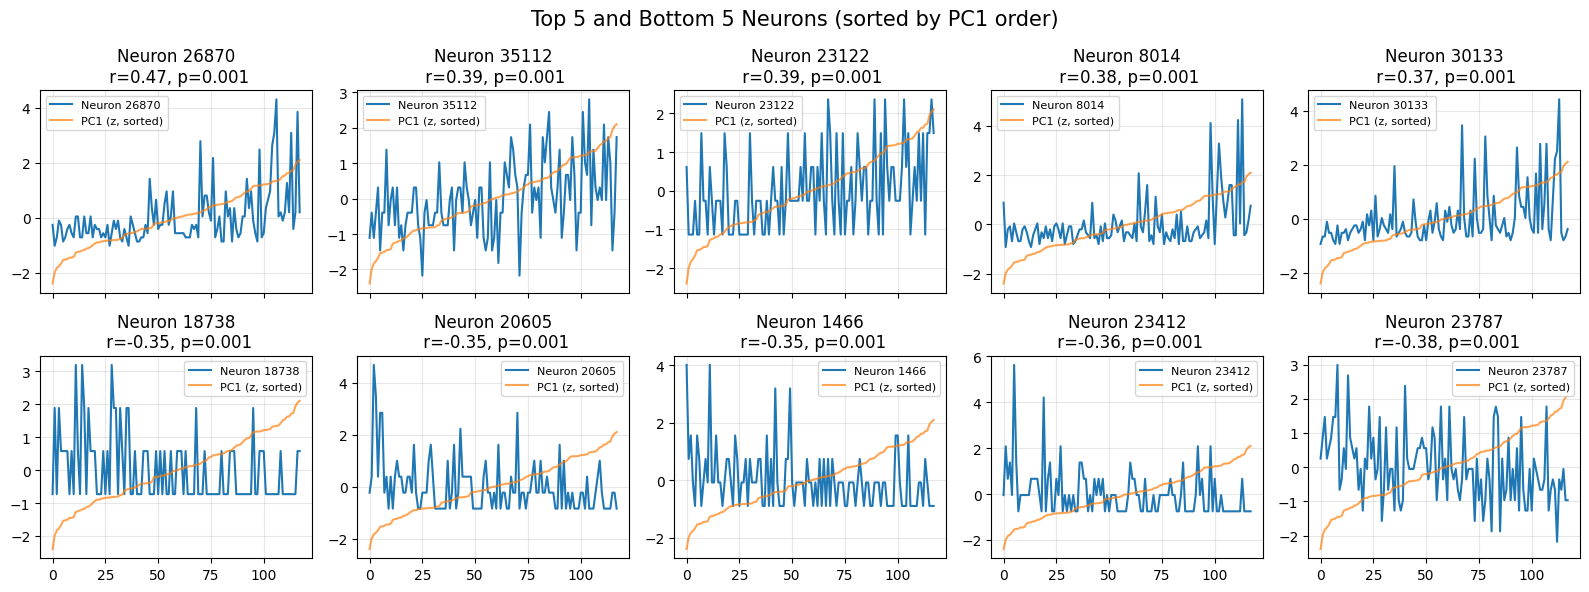

In [12]:
# ---------------------------------------------------------------
# SORT IMAGES BY PC1 VALUE
# ---------------------------------------------------------------
sort_idx = np.argsort(pc1)
pc1_sorted = pc1[sort_idx]
pc1_z_sorted = (pc1_sorted - pc1_sorted.mean()) / pc1_sorted.std()

# ---------------------------------------------------------------
# PLOT (sorted by PC1)
# ---------------------------------------------------------------
fig, axes = plt.subplots(2, 5, figsize=(16, 6), sharex=True)
axes = axes.ravel()

for i, idx in enumerate(selected):
    ax = axes[i]
    
    # neuron firing in same sorted PC1 order
    y = firing_mean[idx][sort_idx]
    y_z = (y - y.mean()) / y.std()
    
    ax.plot(y_z, label=f"Neuron {idx}", color="tab:blue", lw=1.5)
    ax.plot(pc1_z_sorted, label="PC1 (z, sorted)", color="tab:orange", alpha=0.7)
    
    r_val = df_perm.loc[df_perm["neuron_idx"] == idx, "r_pc1"].values[0]
    p_val = df_perm.loc[df_perm["neuron_idx"] == idx, "p_perm"].values[0]
    ax.set_title(f"Neuron {idx}\n r={r_val:.2f}, p={p_val:.3f}")
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

fig.suptitle("Top 5 and Bottom 5 Neurons (sorted by PC1 order)", fontsize=15)
plt.tight_layout()
plt.show()


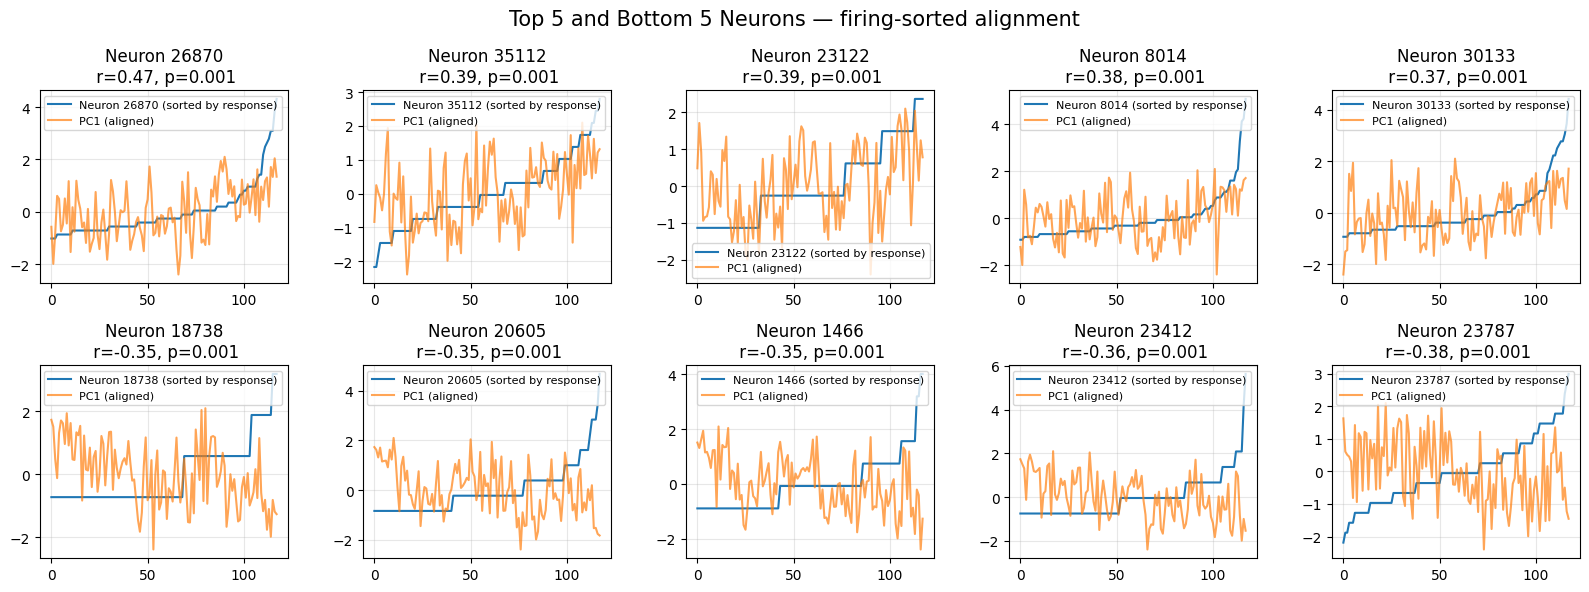

In [13]:
# ---------------------------------------------------------------
# PLOT (each neuron sorted by its own firing pattern)
# ---------------------------------------------------------------
fig, axes = plt.subplots(2, 5, figsize=(16, 6), sharex=False)
axes = axes.ravel()

for i, idx in enumerate(selected):
    ax = axes[i]

    # get this neuron's firing and its sorting order
    y = firing_mean[idx]
    sort_idx = np.argsort(y)
    y_sorted = y[sort_idx]
    pc1_sorted = pc1[sort_idx]

    # z-score both for fair visual scale
    y_z = (y_sorted - y_sorted.mean()) / y_sorted.std()
    pc1_z = (pc1_sorted - pc1_sorted.mean()) / pc1_sorted.std()

    # plot
    ax.plot(y_z, label=f"Neuron {idx} (sorted by response)", color="tab:blue", lw=1.5)
    ax.plot(pc1_z, label="PC1 (aligned)", color="tab:orange", alpha=0.7)

    # stats for title
    r_val = df_perm.loc[df_perm["neuron_idx"] == idx, "r_pc1"].values[0]
    p_val = df_perm.loc[df_perm["neuron_idx"] == idx, "p_perm"].values[0]
    ax.set_title(f"Neuron {idx}\n r={r_val:.2f}, p={p_val:.3f}")
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

fig.suptitle("Top 5 and Bottom 5 Neurons — firing-sorted alignment", fontsize=15)
plt.tight_layout()
plt.show()


In [ ]:
#This was the original script

#!/usr/bin/env python3
"""
PC1–neuron correlation analysis
Averages 50 repeats per image and tests r ≠ 0.
"""

import os, pickle
import numpy as np
import pandas as pd
from scipy.special import softmax
from skbio.stats.composition import clr
from sklearn.decomposition import PCA
from scipy.stats import pearsonr

# ---------------------------------------------------------------
# PATHS
# ---------------------------------------------------------------
VIT_PATH = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy'

N_IMAGES = 118
REPEATS_PER_IMAGE = 50  # 5900 = 118 × 50

# ---------------------------------------------------------------
# LOAD DATA
# ---------------------------------------------------------------
dat = np.load(NEURAL_PATH)  # (n_neurons, 5900)
n_neurons, n_trials = dat.shape
print(f"Neural data shape: {n_neurons} neurons × {n_trials} trials")

# reshape to (neurons, images, repeats)
assert n_trials == N_IMAGES * REPEATS_PER_IMAGE, "Trial count must equal images × repeats"
dat_img_rep = dat.reshape(n_neurons, N_IMAGES, REPEATS_PER_IMAGE)

# average across repeats to get per-image mean firing
firing_mean = dat_img_rep.mean(axis=2)  # (n_neurons, 118)
print("Averaged to per-image firing rates:", firing_mean.shape)

# ---------------------------------------------------------------
# LOAD AND TRANSFORM ViT EMBEDDINGS
# ---------------------------------------------------------------
with open(VIT_PATH, 'rb') as f:
    vit_arr = pickle.load(f)['natural_scenes']
embeddings = np.asarray(vit_arr)
print("ViT embeddings shape:", embeddings.shape)

# softmax + CLR
from scipy.special import softmax
from skbio.stats.composition import clr
X = softmax(embeddings, axis=1)
X_clr = clr(X + 1e-12)

# PCA covering ≥90% variance
from sklearn.decomposition import PCA
pca_full = PCA().fit(X_clr)
cumvar = np.cumsum(pca_full.explained_variance_ratio_)
n_components = np.searchsorted(cumvar, 0.90) + 1
print(f"Selecting {n_components} PCs (covering {100*cumvar[n_components-1]:.2f}% variance)")

pca = PCA(n_components=n_components, random_state=0)
U = pca.fit_transform(X_clr)
pc1 = U[:, 0]  # (118,)

# ---------------------------------------------------------------
# CORRELATION ANALYSIS: PC1 vs firing per neuron
# ---------------------------------------------------------------
results = []
for j in range(n_neurons):
    y = firing_mean[j, :]
    if np.allclose(y, y[0]):  # constant neuron
        results.append((j, np.nan, np.nan))
        continue

    r, p = pearsonr(pc1, y)
    results.append((j, r, p))

df = pd.DataFrame(results, columns=["neuron_idx", "r_pc1", "pval_pc1"])
df.to_csv("corr_pc1.csv", index=False)
print("✅ Saved corr_pc1.csv")
print(df.head())

# Summary
n_sig = np.sum(df["pval_pc1"] < 0.05)
print(f"{n_sig}/{len(df)} neurons show significant correlation with PC1 (p<0.05)")


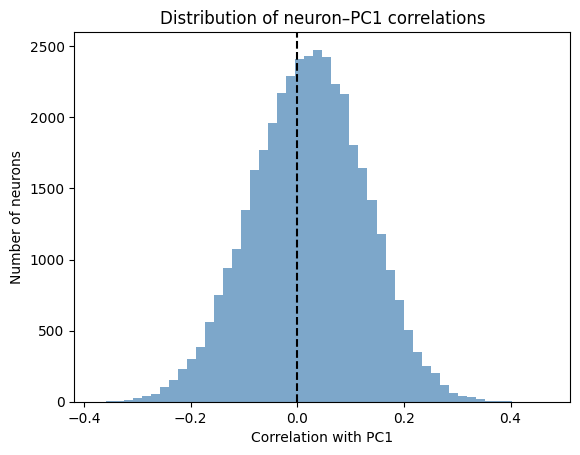

In [4]:
import matplotlib.pyplot as plt
plt.hist(df["r_pc1"].dropna(), bins=50, color="steelblue", alpha=0.7)
plt.axvline(0, color='k', linestyle='--')
plt.xlabel("Correlation with PC1")
plt.ylabel("Number of neurons")
plt.title("Distribution of neuron–PC1 correlations")
plt.show()


In [7]:
from scipy.stats import ttest_1samp
t, p = ttest_1samp(df["r_pc1"].dropna(), 0)
print(f"Population mean r test: t={t:.2f}, p={p:.2e}")

Population mean r test: t=40.30, p=0.00e+00


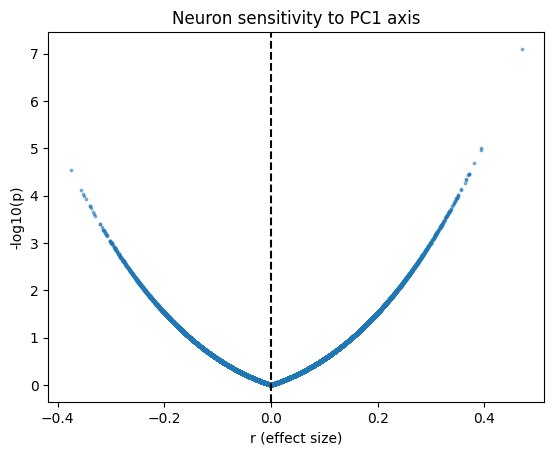

In [5]:
plt.scatter(df["r_pc1"], -np.log10(df["pval_pc1"]), s=3, alpha=0.5)
plt.axvline(0, color='k', linestyle='--')
plt.xlabel("r (effect size)")
plt.ylabel("-log10(p)")
plt.title("Neuron sensitivity to PC1 axis")
plt.show()


In [6]:
from statsmodels.stats.multitest import multipletests
_, p_adj, _, _ = multipletests(df["pval_pc1"], method="fdr_bh")
df["p_adj"] = p_adj
print((df["p_adj"] < 0.05).sum(), "neurons remain significant after FDR")

1 neurons remain significant after FDR


In [8]:
from scipy.stats import ttest_1samp
import numpy as np

# -----------------------------------------
# 1. Population-level t-test of mean r ≠ 0
# -----------------------------------------
r_vals = df["r_pc1"].dropna().to_numpy()
t, p = ttest_1samp(r_vals, 0)
print(f"Population mean r test: t = {t:.2f}, p = {p:.2e}")
print(f"Mean r = {np.mean(r_vals):.4f}, 95% CI ≈ [{np.percentile(r_vals, 2.5):.4f}, {np.percentile(r_vals, 97.5):.4f}]")

# -----------------------------------------
# 2. Permutation-based null distribution
# -----------------------------------------
def permutation_null(firing_mean, pc1, n_perm=1000, seed=0):
    """
    Computes null envelope of mean correlation by shuffling pc1 across images.
    firing_mean: (n_neurons, n_images)
    pc1: (n_images,)
    Returns lower/upper 95% bounds of null mean r distribution.
    """
    rng = np.random.default_rng(seed)
    n_neurons, n_images = firing_mean.shape
    r_null = []
    for _ in range(n_perm):
        shuffled = rng.permutation(pc1)
        # correlation of each neuron with shuffled pc1
        r_perm = [np.corrcoef(firing_mean[j], shuffled)[0,1] for j in range(n_neurons)]
        r_null.append(np.nanmean(r_perm))
    return np.percentile(r_null, [2.5, 97.5])

# Example call:
ci_lo, ci_hi = permutation_null(firing_mean, pc1, n_perm=1000)
print(f"Permutation null 95% envelope for mean r: [{ci_lo:.4f}, {ci_hi:.4f}]")
print(f"Observed mean r = {np.mean(r_vals):.4f}")
if np.mean(r_vals) > ci_hi or np.mean(r_vals) < ci_lo:
    print("✅ Mean correlation is outside the null envelope — population alignment is significant.")
else:
    print("⚪ Mean correlation falls within the null envelope — no population-level effect detected.")


Population mean r test: t = 40.30, p = 0.00e+00
Mean r = 0.0213, 95% CI ≈ [-0.1864, 0.2208]


KeyboardInterrupt: 

In [9]:
import numpy as np
from tqdm import tqdm  # progress bar (optional)

def perm_test_corr_per_neuron(firing_mean, pc1, n_perm=1000, seed=0):
    """
    Compute permutation-based correlation p-values per neuron.
    
    firing_mean: (n_neurons, n_images)
    pc1: (n_images,)
    Returns: r (corr coeffs), p_perm (empirical p-values)
    """
    rng = np.random.default_rng(seed)
    n_neurons, n_images = firing_mean.shape
    
    # observed correlations
    r_obs = np.array([np.corrcoef(firing_mean[j], pc1)[0,1] for j in range(n_neurons)])
    
    # permutation nulls
    p_perm = np.empty(n_neurons)
    for j in tqdm(range(n_neurons), desc="Permuting neurons"):
        null_r = []
        for _ in range(n_perm):
            shuffled = rng.permutation(pc1)
            null_r.append(np.corrcoef(firing_mean[j], shuffled)[0,1])
        null_r = np.abs(null_r)
        p_perm[j] = (1 + np.sum(null_r >= abs(r_obs[j]))) / (1 + n_perm)
    
    return r_obs, p_perm

r_perm, p_perm = perm_test_corr_per_neuron(firing_mean, pc1, n_perm=1000)
df_perm = pd.DataFrame({
    "neuron_idx": np.arange(len(r_perm)),
    "r_pc1": r_perm,
    "p_perm": p_perm
})
df_perm.to_csv("corr_pc1_perm.csv", index=False)
print(f"✅ Saved permutation-based results for {len(df_perm)} neurons")
print(f"Neurons with p_perm<0.05: {(df_perm['p_perm']<0.05).sum()} / {len(df_perm)}")



Permuting neurons: 100%|██████████| 39209/39209 [32:01<00:00, 20.40it/s]


✅ Saved permutation-based results for 39209 neurons
Neurons with p_perm<0.05: 3506 / 39209


In [2]:
dat = np.load('/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy')
print(dat.shape)

(39209, 5900)
